<a href="https://colab.research.google.com/github/linyuehzzz/5523_project/blob/main/sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Stochastic Gradient Descent for Logistic Regression**
This code implements and tests the SGD algorithm for logistic regression
in different scenarios.  
Yifei Zhang (zhang.5387 at osu edu), Yue Lin (lin.3326 at osu.edu)  
Created: 11/12/2020

#### **Set up libraries**

In [171]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#### **Project**

##### Projection function for hypercube

In [172]:
def cube_prj(sample):
  '''
  input: a sample with d dimension (1-D array or list)
  onput: the euclidean projection of sample
  '''
  return [np.sign(i) * min(np.abs(i), 1) for i in sample]

##### Projection function for unit ball

In [173]:
def ball_prj(sample):
    '''
    input: a sample with d dimension (1-D array or list)
    onput: the euclidean projection of sample
    '''
    ratio = 1 / np.linalg.norm(sample)
    return [i * ratio for i in sample]

##### Project data

In [174]:
def prj_data(x, y, prj_code):
    '''
    This function is for conduct projection on data array
    x: n*d array (n is sample#, d is dimension)
    y: 1-d array with label of -1 or +1
    prj_code: type of projection, 0 for cube, 1 for ball
    return:
        prj_x: projected x 
        y: same as input
    '''
    if prj_code == 0:
        prj_x = np.apply_along_axis(cube_prj, 1, x)
    elif prj_code == 1:
        prj_x = np.apply_along_axis(ball_prj, 1, x)
    else:
        print("Please input correct code for projection type: 0 for cube, 1 for ball")
      
    b = np.ones((prj_x.shape[0], 1))
    prj_x = np.append(prj_x, b, axis=1)
    return prj_x, y

##### Project gradient

In [175]:
def prj_grad(g, prj_code):
    '''
    This function is for conduct projection on gradients
    g: 1-d array (d is dimension)
    prj_code: type of projection, 0 for cube, 1 for ball
    return:
        prj_g: projected gradient
    '''
    if prj_code == 0:
        prj_g = cube_prj(g)
    elif prj_code == 1:
        prj_g = ball_prj(g)
    else:
        print("Please input correct code for projection type: 0 for cube, 1 for ball")
    return prj_g

#### **Prepare data**

In [176]:
def gen_data(sig, n):
    '''
    The function is to generate data for training and testing
    The feature array is 4 dimension array. 
     + Each feature follows the Normal distribution(mu,sig)
     + with probability 1/2, the y =1 , 
         generate the correspoinding feature vector from N(mu,sig),mu is [1/4,1/4,1/4,1/4],sig is set as you need.
    sig: the sigma of  gussian vector
    n: the sample number
    
    Return:
     x: n*d_dimension array
     y: 1-d dimension array with -1 and +1
    '''
    d_dimension = 4
    y = np.random.choice([-1, 1], p = [0.5, 0.5], size = n)
    x = np.array([])
    for i in range(n):
        if y[i] == -1:
            mu = -(1 / 4)
            negvec = np.random.normal(mu, sig, d_dimension)
            x = np.concatenate([x, negvec], axis=0)
        else:
            mu = (1 / 4)
            posvec = np.random.normal(mu, sig, d_dimension)
            x = np.concatenate([x, posvec], axis=0)
    x = np.reshape(x, (n, d_dimension))
    return x, y

#### **Train**
https://machinelearningmastery.com/implement-logistic-regression-stochastic-gradient-descent-scratch-python/

##### Predict using logistic regression

In [177]:
# Make a prediction with coefficients
def pred(X, w):
  yhat = 0.
  for i in range(X.shape[0]):
    yhat += w[i] * X[i]
  yhat = 1.0 / (1.0 + np.exp(-yhat))
  if yhat < 0.5:
    yhat = -1
  else:
    yhat = 1 
  return yhat

##### Estimate logistic loss

In [178]:
def log_loss(X, y, w):
  return np.log(1 + np.exp(-y * np.dot(w.T, X)))

##### Estimate classification error

In [179]:
def err(yhat, y):
  if yhat == y:
    return 0
  else:
    return 1

##### Estimate weight vector using SGD

In [180]:
def train_sgd(train_x, train_y, test_x, test_y, l_rate, n_epoch, bs, prj_code):
  w = np.random.uniform(-1, 1, (train_x.shape[1]))
  risk_all = []
  cls_err_all = []

  for epoch in range(n_epoch):
    risk = cls_err = 0.
    grad = []
    for idx in range(epoch * bs, (epoch + 1) * bs):
      # Read data
      X = train_x[idx]
      y = train_y[idx]
      # Calculate gradient
      g = (-y * X * np.exp(-y * np.dot(w.T, X)) / (1 + np.exp(-y * np.dot(w.T, X))))
      g = prj_grad(g, prj_code)
      grad = np.append(grad, g)

    # Project gradient
    grad = np.average(np.array(grad), axis=0)
    # Backward propagation
    w = np.add(w, np.multiply(-l_rate, grad))
    
    # Evaluate
    for idx in range(test_x.shape[0]):
      # Read data
      X = test_x[idx]
      y = test_y[idx]
      # Predict
      yhat = pred(X, w)
      # Evaluate
      risk += log_loss(X, y, w) / test_x.shape[0]
      cls_err += err(yhat, y) / test_x.shape[0]
    
    risk_all = np.append(risk_all, risk)
    cls_err_all = np.append(cls_err_all, cls_err)
    # print('>epoch=%d, lrate=%.3f, risk=%.3f, classification error=%.3f' % (epoch, l_rate, risk, cls_err))
  
  # Report risk
  # print(risk_all, cls_err_all)
  risk_ave = np.average(risk_all)
  risk_min = np.amin(risk_all)
  risk_var = np.sqrt(np.var(risk_all))
  exp_excess_risk = risk_ave - risk_min
  # Report classification error
  cls_err_ave = np.average(cls_err_all)
  cls_err_var = np.sqrt(np.var(cls_err_all))
  return [w, risk_ave, risk_min, risk_var, exp_excess_risk, cls_err_ave, cls_err_var]

#### **Wrapper test**

##### Generate data and train

In [181]:
# Fixed hyperparameters
n_epoch = 30    # training epochs
test_n = 400    # size of test set

# Unfixed hyperparameters
prj_code = 1    # code for two scenario: 0 for cube, 1 for ball
l_rate = 0.001  # learning rate: 0.04 for cube, 0.18 for ball
train_bs = np.array([50, 100, 500, 1000])   # batch size for each training epoch
sigma = 0.1     # variance of Gaussian distribution

np.random.seed(1)

excess_risk = []
cls_error = []
excess_risk_var = []
cls_error_var = []

for bs in train_bs:
  # Generate training data
  train_x, train_y = gen_data(sigma, bs * n_epoch)
  train_px, train_py = prj_data(train_x, train_y, prj_code)

  # Generate test data
  test_x, test_y = gen_data(sigma, test_n)
  test_px, test_py = prj_data(test_x, test_y, prj_code)

  # Train
  output = train_sgd(train_px, train_py, test_px, test_py, l_rate, n_epoch, bs, prj_code)
  print(output)
  print('>scenario=%d, sigma=%.2f, n=%d, log_loss_mean=%.3f, log_loss_std_dev=%.3f, log_loss_min=%.3f, \
        excess_risk=%.3f, cls_error_mean=%.3f, cls_error_std_dev=%.3f' 
        % (prj_code+1, sigma, bs, output[1], output[3], output[2], output[4], output[5], output[6]))
  
  excess_risk = np.append(excess_risk, output[4], axis=None)
  cls_error = np.append(cls_error, output[5],  axis=None)
  excess_risk_var = np.append(excess_risk_var, output[3], axis=None)
  cls_error_var = np.append(cls_error_var, output[6],  axis=None)

[array([ 0.54239154, -0.01298581, -0.81752684, -0.15825542, -0.1115001 ]), 0.8212370861676764, 0.817166125000965, 0.0024430904968395176, 0.004070961166711462, 0.8412499999999928, 0.002015564437074594]
>scenario=2, sigma=0.10, n=50, log_loss_mean=0.821, log_loss_std_dev=0.002, log_loss_min=0.817,         excess_risk=0.004, cls_error_mean=0.841, cls_error_std_dev=0.002
[array([-0.29993697,  0.13810088, -0.58224057,  0.79992246, -0.76196232]), 0.7686103657784199, 0.7641461624209505, 0.002661814126055694, 0.004464203357469443, 0.5175, 0.0]
>scenario=2, sigma=0.10, n=100, log_loss_mean=0.769, log_loss_std_dev=0.003, log_loss_min=0.764,         excess_risk=0.004, cls_error_mean=0.517, cls_error_std_dev=0.000
[array([0.30507916, 0.90869952, 0.82884483, 0.4089651 , 0.04243657]), 0.2752046235979267, 0.27341592618842714, 0.0010646706958701742, 0.0017886974094995511, 0.0, 0.0]
>scenario=2, sigma=0.10, n=500, log_loss_mean=0.275, log_loss_std_dev=0.001, log_loss_min=0.273,         excess_risk=0.00

##### Plot excess risk

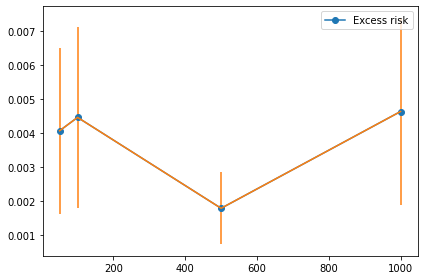

In [182]:
plt.plot(train_bs, excess_risk, '-o', label='Excess risk')
plt.errorbar(train_bs, excess_risk, excess_risk_var)
plt.legend()
plt.tight_layout()
plt.show()

##### Plot classification error

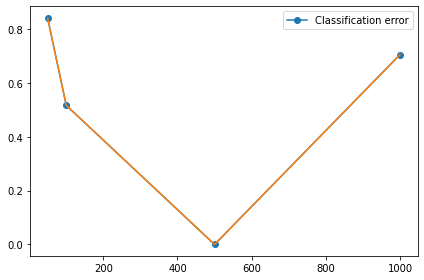

In [183]:
plt.plot(train_bs, cls_error, '-o', label='Classification error')
plt.errorbar(train_bs, cls_error, cls_error_var)
plt.legend()
plt.tight_layout()
plt.show()

#### **Wrapper**

In [184]:
# Fixed hyperparameters
n_epoch = 30    # training epochs
test_n = 400    # size of test set

# Unfixed hyperparameters
prj_code = 0   # code for two scenario: 0 for cube, 1 for ball
# l_rate = 0.04  # learning rate: 0.16 for cube, 0.07 for ball
train_bs = np.array([50, 100, 500, 1000])  # batch size for each training epoch
sigma = 0.1     # variance of Gaussian distribution
np.random.seed(0)

##### Run all experiments

In [185]:
result_list = []
for prj_code in [0, 1]:
    if prj_code == 0:
        l_rate = 0.16
    else:
        l_rate = 0.07
    for sigma in [0.1, 0.35]:
        for bs in train_bs:
          # Generate training data
            train_x, train_y = gen_data(sigma, bs * n_epoch)
            train_px, train_py = prj_data(train_x, train_y, prj_code)

            # Generate test data
            test_x, test_y = gen_data(sigma, test_n)
            test_px, test_py = prj_data(test_x, test_y, prj_code)

            # Train
            output = train_sgd(train_px, train_py, test_px, test_py, l_rate, n_epoch, bs, prj_code)
            #[w, risk_ave, risk_min, risk_var, exp_excess_risk, cls_err_ave, cls_err_var]

#             print(output)
#             print('>scenario=%d, sigma=%.2f, n=%d, log_loss_mean=%.3f, log_loss_std_dev=%.3f, log_loss_min=%.3f, \
#                 excess_risk=%.3f, cls_error_mean=%.3f, cls_error_std_dev=%.3f' 
#                 % (prj_code+1, sigma, bs, output[1], output[3], output[2], output[4], output[5], output[6]))
            result = [prj_code+1, sigma, bs, n_epoch,output[1], output[3], output[2], output[4], output[5], output[6]]
            result_list.append(result)

##### Plot table

In [186]:
column_name = ["Scenario", "sigma", "N", "#trails", "Loss_Mean", "Loss_StdDev", "Loss_Min", "Loss_ExcessRisk",
             "Error_Mean", "Error_StdDev"]
result_df = pd.DataFrame(result_list, columns = column_name)
result_df

,Scenario,sigma,N,#trails,Loss_Mean,Loss_StdDev,Loss_Min,Loss_ExcessRisk,Error_Mean,Error_StdDev
0,1,0.10,50,30,0.575124,0.011764,0.557031,0.018093,0.501667,5.217492e-03
1,1,0.10,100,30,0.666319,0.035225,0.615797,0.050522,0.522833,1.067187e-03
2,1,0.10,500,30,0.753131,0.027881,0.712699,0.040432,0.520000,1.110223e-16
3,1,0.10,1000,30,0.684456,0.033304,0.635868,0.048588,0.487500,1.110223e-16
4,1,0.35,50,30,0.599955,0.032168,0.556394,0.043562,0.350167,2.818786e-02
5,1,0.35,100,30,0.756644,0.108482,0.602864,0.153781,0.480417,1.045508e-01
6,1,0.35,500,30,0.512708,0.006163,0.503531,0.009177,0.307750,5.178079e-03
7,1,0.35,1000,30,0.627080,0.046673,0.562243,0.064837,0.332250,8.212123e-02
8,2,0.10,50,30,0.453024,0.062524,0.360058,0.092966,0.367083,9.181749e-02
9,2,0.10,100,30,0.385723,0.054572,0.303239,0.082484,0.185333,9.666034e-02


##### Plot grid

In [187]:
def plot_result(estimator, result_df):
    '''
    estimator: 
        0 is for ["Loss_ExcessRisk", "Loss_StdDev"]
        1 is for ["Error_Mean", "Error_StdDev"]
    result_df:
        result table above
    
    '''
    if estimator == 0:
        col = ["Loss_ExcessRisk", "Loss_StdDev"]
    else:
        col = ["Error_Mean", "Error_StdDev"]
        
    fig = plt.figure(figsize = (16, 10))
    index = 0
    for senario in [1, 2]:
        for sigma in [0.1, 0.35]:
            index += 1
            plt.subplot(2, 2, index)
            df = result_df[np.logical_and(result_df["Scenario"] == senario, result_df["sigma"] == sigma)]
            excess_risk, excess_risk_var = df[col[0]], df[col[1]]

            plt.plot(train_bs, excess_risk, '-o', label = col[0])
            plt.errorbar(train_bs, excess_risk, excess_risk_var)

            plt.xlabel("N", fontsize = 12)
            plt.xticks(fontsize = 12)
            plt.ylabel("Risk", fontsize = 12)
            plt.yticks(fontsize = 12)
            plt.title("Scenario " + str(senario) + ", Sigma=" + str(sigma), fontsize=15) 
    fig.legend(col, loc = "upper right", fontsize = 13)
    plt.tight_layout()
    plt.show()

###### Plot excess risk

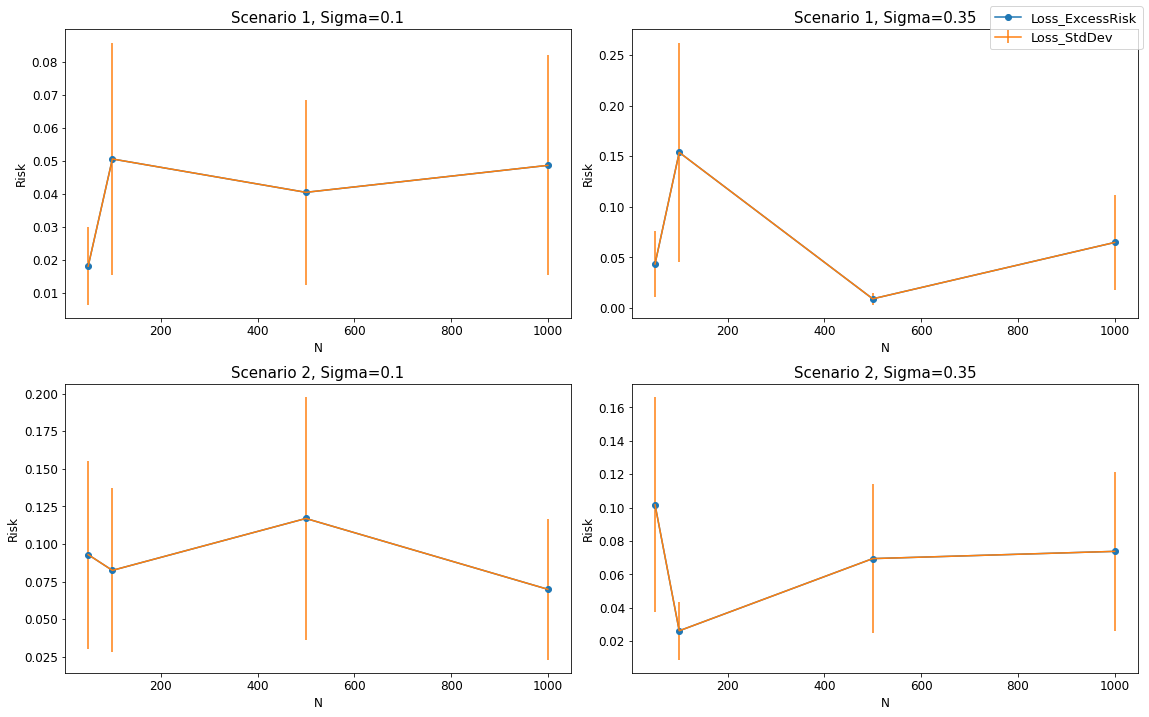

In [188]:
plot_result(0, result_df)

###### Plot classification error

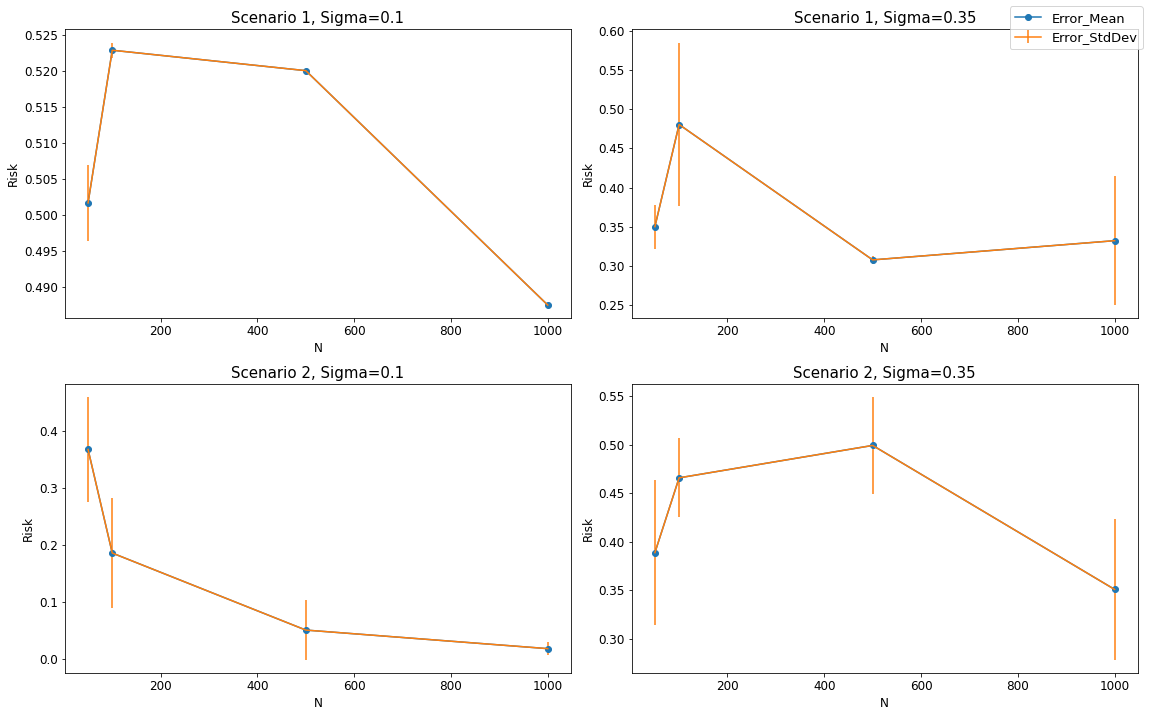

In [189]:
plot_result(1, result_df)